# Supervised baselines

Notebook with strong supervised learning baseline on cifar-10

In [ ]:
%reload_ext autoreload
%autoreload 2

You probably need to install dependencies

In [ ]:
# All things needed

!git clone https://github.com/puhsu/sssupervised
!pip install -q fastai2
!pip install -qe sssupervised

Cloning into 'sssupervised'...
remote: Enumerating objects: 156, done.
remote: Counting objects: 100% (156/156), done.
remote: Compressing objects: 100% (126/126), done.
remote: Total 156 (delta 26), reused 146 (delta 19), pack-reused 0
Receiving objects: 100% (156/156), 1.34 MiB | 31.08 MiB/s, done.
Resolving deltas: 100% (26/26), done.
     |████████████████████████████████| 184kB 18.0MB/s 


After running cell above you should restart your kernel

In [ ]:
from sssupervised.cifar_utils import CifarFactory
from sssupervised.randaugment import RandAugment

from fastai2.data.transforms import parent_label, Categorize

from fastai2.optimizer import ranger, Adam

from fastai2.layers import LabelSmoothingCrossEntropy
from fastai2.metrics import error_rate

from fastai2.callback.all import *
from fastai2.vision.all import *

Baseline uses wideresnet-28-2 model with randaugment augmentation policy. It is optiimzed with RAadam with lookahead with one-cycle learning rate and momentum schedules for 200 epochs (we count epochs in number of steps on standard cifar, so we set 4000 epochs in our case, because we only have $2400$ training examples ($50000/2400 \approx 20$)

In [ ]:
cifar = untar_data(URLs.CIFAR)
files, (train, test, unsup) = CifarFactory(n_same_cls=3, seed=42, n_labeled=400).splits_from_path(cifar)

sup_ds = Datasets(files, [[PILImage.create, RandAugment, ToTensor], [parent_label, Categorize]], splits=(train, test))
sup_dl = sup_ds.dataloaders(after_batch=[IntToFloatTensor, Normalize.from_stats(*cifar_stats)])

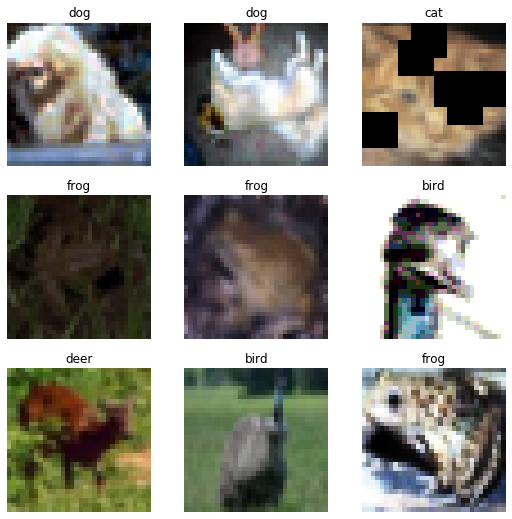

In [ ]:
sup_dl.train.show_batch(max_n=9)

In [ ]:
# https://github.com/uoguelph-mlrg/Cutout

import math
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, dropRate=0.0):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                               padding=0, bias=False) or None

    def forward(self, x):
        if not self.equalInOut: x   = self.relu1(self.bn1(x))
        else:                   out = self.relu1(self.bn1(x))
        out = self.relu2(self.bn2(self.conv1(out if self.equalInOut else x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        out = self.conv2(out)
        return torch.add(x if self.equalInOut else self.convShortcut(x), out)

class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, dropRate=0.0):
        super().__init__()
        self.layer = self._make_layer(block, in_planes, out_planes, nb_layers, stride, dropRate)
    def _make_layer(self, block, in_planes, out_planes, nb_layers, stride, dropRate):
        layers = []
        for i in range(nb_layers):
            layers.append(block(i == 0 and in_planes or out_planes, out_planes, i == 0 and stride or 1, dropRate))
        return nn.Sequential(*layers)
    def forward(self, x): return self.layer(x)

class WideResNet(nn.Module):
    def __init__(self, depth, num_classes, widen_factor=1, dropRate=0.0):
        super().__init__()
        nChannels = [16, 16*widen_factor, 32*widen_factor, 64*widen_factor]
        assert((depth - 4) % 6 == 0)
        n = (depth - 4) // 6
        block = BasicBlock
        # 1st conv before any network block
        self.conv1 = nn.Conv2d(3, nChannels[0], kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.block1 = NetworkBlock(n, nChannels[0], nChannels[1], block, 1, dropRate)
        self.block2 = NetworkBlock(n, nChannels[1], nChannels[2], block, 2, dropRate)
        self.block3 = NetworkBlock(n, nChannels[2], nChannels[3], block, 2, dropRate)
        self.bn1 = nn.BatchNorm2d(nChannels[3])
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(nChannels[3], num_classes)
        self.nChannels = nChannels[3]

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear): m.bias.data.zero_()
    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(-1, self.nChannels)
        return self.fc(out)

def wrn_22(): return WideResNet(depth=22, num_classes=10, widen_factor=6, dropRate=0.)
def wrn_22_k8(): return WideResNet(depth=22, num_classes=10, widen_factor=8, dropRate=0.)
def wrn_22_k10(): return WideResNet(depth=22, num_classes=10, widen_factor=10, dropRate=0.)
def wrn_22_k8_p2(): return WideResNet(depth=22, num_classes=10, widen_factor=8, dropRate=0.2)
def wrn_28(): return WideResNet(depth=28, num_classes=10, widen_factor=6, dropRate=0.)
def wrn_28_k8(): return WideResNet(depth=28, num_classes=10, widen_factor=8, dropRate=0.)
def wrn_28_k8_p2(): return WideResNet(depth=28, num_classes=10, widen_factor=8, dropRate=0.2)
def wrn_28_p2(): return WideResNet(depth=28, num_classes=10, widen_factor=6, dropRate=0.2)

We override default callbacks (the best way I found, to pass extra arguments to callbacks)

In [ ]:
defaults.callbacks = [
    TrainEvalCallback(),
    Recorder(train_metrics=True),
    ProgressCallback(),
]

In [ ]:
class SkipSomeValidations(Callback):
    """Perform validation regularly, but not every epoch 
    (usefull for small datasets, where training is quick)"""
    def __init__(self, n_epochs=20): self.n_epochs=n_epochs
    def begin_validate(self):
        if self.train_iter % self.n_epochs != 0:
            raise CancelValidException()

In [ ]:
learner = Learner(
    sup_dl, 
    wrn_28(),
    CrossEntropyLossFlat(),
    opt_func=ranger, 
    wd=1e-2, 
    metrics=error_rate,
    cbs=[ShowGraphCallback(), SkipSomeValidations(n_epochs=20)]
)